In [1]:
from glob import glob
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import wilcoxon
import pingouin as pg

from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics.simulated_annealing_multi_order import simulated_annealing_multi_order
from thoi.heuristics import greedy

rcParams = {
    'axes.titlesize': 14,
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'lines.linewidth': 2,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
}
sns.set_context("paper", font_scale=2, rc=rcParams)

state_colors = {
    'Awake': sns.color_palette()[2],
    'Deep': sns.color_palette()[4]
}

fig_path = '/home/laouen.belloli/Documents/git/Oinformation/analysis/figures/anesthesia'

w: 411,51019
h: 299,21558

Arial 
title: 30
label: 27
ax title: 23
ax tick label: 20
ax tick: 17

Segments: 25

In [2]:
# plot version of the libraries

print(' --- Library versions --- ')
print('\t- Pandas version:', pd.__version__)
print('\t- Seaborn version:', sns.__version__)
print('\t- Numpy version:', np.__version__)
print('\t- Pingouin version:', pg.__version__)
print('\t- Matplotlib version:', plt.matplotlib.__version__)
print('\t- Scipy version:', wilcoxon.__module__)
print(' ------------------------ ')

 --- Library versions --- 
	- Pandas version: 2.2.3
	- Seaborn version: 0.13.2
	- Numpy version: 1.26.4
	- Pingouin version: 0.5.5
	- Matplotlib version: 3.9.2
	- Scipy version: scipy.stats._morestats
 ------------------------ 


* Exaustivo y quedarnos con:
  * AUC: min, median, max
  * bet k por order de iteración (1000)
* Greedy:
  * AUC
  * ML cross-val (para el notebook)
* simulated annealing multi order:
  * AUC
  * ML cross-val (para el notebook)

In [3]:
root = '/home/laouen.belloli/Documents/data/Oinfo/fmri_anesthesia/42003_2023_5063_MOESM3_ESM/nets_by_subject'
#states_all = ['Awake', 'Deep', 'Mild', 'Recovery']
states_all = ['Awake', 'Deep']

dfs_dict = {}
for state in states_all:
    # list all folder in root/state
    folders = glob(os.path.join(root, state, '*'))
    for folder in folders:
        network = os.path.basename(folder).replace('_parcellation_5', '')
        
        # List all csv files in folder
        csv_files = glob(os.path.join(folder, f'ts_{network}_parcellation_5_Sub*.csv'))
        for csv_file in csv_files:
            sub = int(os.path.basename(csv_file).split('_')[-1].split('.')[0].replace('Sub', ''))
            
            # Read csv file and add information columns
            df = pd.read_csv(csv_file, sep=',', header=None)
            
            # Convert the columns in multilavel, add the network to a second lavel
            df.columns = pd.MultiIndex.from_product([[network], range(df.shape[1])])
            
            # Add df to dfs dict
            if sub not in dfs_dict:
                dfs_dict[sub] = {}
            
            if state not in dfs_dict[sub]:
                dfs_dict[sub][state] = []
            
            dfs_dict[sub][state].append(df)

# Concatenate all dataframes into a single one
dfs_list = []
for sub, states in dfs_dict.items():
    for state, dfs in states.items():
        df = pd.concat(dfs, axis=1)
        df['sub'] = sub
        df['state'] = state
        df = df[[('sub',''), ('state','')] + [col for col in df.columns if col[0] not in ['sub', 'state']]]
        dfs_list.append(df)

df = pd.concat(dfs_list, axis=0)

# Remove sub10 that has no some missing networks
df = df[df['sub'] != 10]

# Check Show missing values (should be none), all subjects have all the networks
assert df.isnull().sum().sum() == 0, 'There are missing values'

# Check all subjects have same lenght across states and networks
assert df.groupby(['sub','state']).size().unique() == [245], 'Series lenght is not the same for all subjects'

networks = df.columns.get_level_values(0).unique()[2:]
#network_pairs = list(combinations(networks, 2))

# Create the list of datsa
Xs = [
    df[(df['sub'] == sub) & (df['state'] == state)][networks].values
    for state in states_all
    for sub in sorted(df['sub'].unique())
]

Xs_awake = Xs[:16]
Xs_deep = Xs[16:]

df_columns = np.array([tuple(col) for col in df[networks].columns])

print(networks)

df

Index(['VentralAttn', 'CinguloParie', 'Visual', 'SMmouth', 'SMhand',
       'CinguloOperc', 'RetrosplenialTemporal', 'Default', 'Auditory',
       'DorsalAttn', 'FrontoParietal'],
      dtype='object')


sub  state VentralAttn                         CinguloParie              \
                         0     1     2     3     4            0     1     2   
0    12  Awake       -0.26  0.50  0.36  0.12  0.33        -0.04 -0.14 -0.03   
1    12  Awake       -0.56  0.01 -0.13  0.15 -0.23         0.75 -0.56 -0.79   
2    12  Awake       -0.67  0.34 -0.18  0.26  0.13         1.09 -0.53 -0.67   
3    12  Awake       -0.64  1.28  0.22  0.49  1.32         0.93 -0.02  0.26   
4    12  Awake       -0.62  1.77  0.69  0.75  2.35         0.58  0.54  1.12   
..   ..    ...         ...   ...   ...   ...   ...          ...   ...   ...   
240   5   Deep       -0.45 -0.27  1.06  0.55  1.01        -2.20  0.66 -0.26   
241   5   Deep        0.08 -0.07  1.26  0.46  1.48        -2.35  0.96  0.28   
242   5   Deep        0.68  0.01  0.91  0.11  1.36        -1.73  0.92  0.93   
243   5   Deep        0.68  0.01  0.37 -0.17  0.78        -0.86  0.57  0.88   
244   5   Deep       -0.00  0.01 -0.09 -0.24  0.02        -0.10  0.04  0.05   

     ... DorsalAttn                         FrontoParietal                    \
     ...          0     1     2     3     4              0     1     2     3   
0    ...      -0.02  0.20 -0.14  0.08  0.07           0.27  0.07  0.13  0.16   
1    ...      -0.81 -1.36 -1.52 -0.71  0.13          -1.06 -1.06 -0.32  0.31   
2    ...      -0.98 -2.05 -2.35 -1.16  0.09          -1.40 -1.42 -0.30  0.44   
3    ...      -0.45 -1.66 -2.36 -1.11  0.04          -0.60 -0.86  0.19  0.56   
4    ...       0.29 -0.70 -1.70 -0.65  0.21           0.58  0.07  0.75  0.71   
..   ...        ...   ...   ...   ...   ...            ...   ...   ...   ...   
240  ...       1.32  0.23  0.24  2.04  2.31          -1.43 -0.39 -0.10  0.85   
241  ...       0.83  0.44  0.48  2.47  1.45          -0.77 -0.36 -0.12  0.59   
242  ...      -0.10  0.22  0.54  1.88  0.17           0.09 -0.16 -0.13  0.09   
243  ...      -0.46 -0.07  0.34  0.89 -0.38           0.37  0.01 -0.13 -0.17   
244  ...      -0.06 -0.22 -0.06 -0.01 -0.02          -0.00  0.08 -0.14 -0.10   

           
        4  
0   -0.23  
1   -0.90  
2   -1.31  
3   -1.32  
4   -0.95  
..    ...  
240 -1.40  
241 -1.30  
242 -0.59  
243 -0.04  
244  0.09  

[7840 rows x 57 columns]

# Greedy

In [4]:
solution_greedy_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_greedy_effect_size_max.npy')
scores_greedy_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_greedy_effect_size_max.npy')

solution_greedy_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_greedy_effect_size_min.npy')
scores_greedy_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_greedy_effect_size_min.npy')

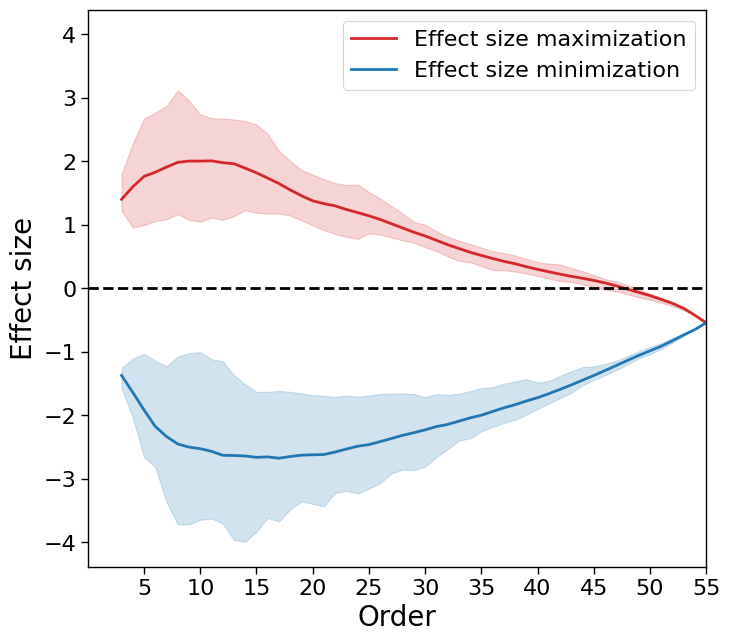

In [20]:
# Plot effect size maximization

best_order = scores_greedy_max.mean(axis=0).argmax()+3
max_score = scores_greedy_max.max()

blue = sns.color_palette()[0]
red = sns.color_palette()[3]

df_scores_greedy = pd.DataFrame([
    (o+3, r, scores_greedy_max[r, o])
    for o in range(scores_greedy_max.shape[1])
    for r in range(scores_greedy_max.shape[0])
], columns=['order', 'repeat', 'score'])

fig, ax = plt.subplots(figsize=(1.2*6.4, 6.8))

sns.lineplot(
    x=df_scores_greedy['order'],
    y=df_scores_greedy['score'],
    data=df_scores_greedy,
    dashes=False, 
    label='Effect size maximization',
    errorbar=lambda x: (x.min(), x.max()),
    color=red,
    ax=ax
)

# Plot a line in the maximum mean o from zero to top height
#ax.axvline(best_order, color='red', linestyle='--', ymin=0.5, ymax=1)

# Plot effect size minimization

best_order = scores_greedy_min.mean(axis=0).argmin()+3
min_score = scores_greedy_min.min()

df_scores_greedy = pd.DataFrame([
    (o+3, r, scores_greedy_min[r, o])
    for o in range(scores_greedy_min.shape[1])
    for r in range(scores_greedy_min.shape[0])
], columns=['order', 'repeat', 'score'])

sns.lineplot(
    x=df_scores_greedy['order'],
    y=df_scores_greedy['score'],
    data=df_scores_greedy,
    dashes=False,
    label='Effect size minimization',
    errorbar=lambda x: (x.min(), x.max()),
    color=blue,
    ax=ax
)

# Plot a line in the minimum mean o
#ax.axvline(best_order, color='red', linestyle='--', ymin=0.5, ymax=0)

# Make y limits symetric
max_score = max(max_score, -min_score)* 1.1
ax.set_ylim(-max_score, max_score)

# plot zero line
ax.axhline(0, color='black', linestyle='--')

# Plot the best order for the maximization
ax.set_xlim(0,df_scores_greedy['order'].max())

ax.set_xlabel('Order')
ax.set_ylabel('Effect size')
#ax.set_yscale('log')

# set x ticks at 5, 10, 15, 20, 25, ...
ax.set_xticks(np.arange(5, 56, 5))

plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'effect_size_greedy_by_order.pdf'))
plt.show()

In [6]:
def plot_contrast(Xs, nplet, metric = 'o', text_left=True, text_top=False):
    
    # Size to fit 4 instead of 3 horizontal
    fig, ax = plt.subplots(figsize=(4.8, 5.1))
    
    order = nplet.shape[0]
    metric_idx = ['dtc', 'tc', 'o', 's'].index(metric)
    
    o = nplets_measures(Xs, nplet.reshape(1, -1))[0, :, metric_idx]

    x = o[:len(o) // 2]
    y = o[len(o) // 2:]

    pval = wilcoxon(x, y, alternative='two-sided').pvalue
    effect_size = pg.compute_effsize(y, x, eftype='cohen') # x and y inverted to have deep - awake

    df_greedy_best = pd.DataFrame({
        'o': o,
        'subject': np.concatenate([np.arange(16), np.arange(16)]),
        'state': np.concatenate([np.repeat('Awake', 16), np.repeat('Deep', 16)])
    })

    # Plot violin plots of the best nplets with state in the x acess and o in the y axis
    sns.violinplot(
        data=df_greedy_best,
        x='state',
        y='o',
        cut=0,
        alpha=0.5,
        palette=state_colors,
        legend=False,
        ax=ax
    )

    # add stripplot and connect the dots between the same subjects
    sns.stripplot(
        data=df_greedy_best,
        x='state',
        y='o',
        jitter=False,          # Disable jitter for alignment
        size=8,
        palette=state_colors,
        edgecolor='auto',
        alpha=0.7,
        ax=ax
    )

    # Connect each subject's paired measurements with lines
    for subject, subject_data in df_greedy_best.groupby('subject'):
        subject_data = subject_data.sort_values('state')
        plt.plot(
            subject_data['state'],
            subject_data['o'],
            marker='o',
            color='black',
            alpha=0.5,
            linewidth=1
        )

    #ax.set_title(f'order: {order} - p-value: {pval:.2e} - Effect size: {effect_size:.2f}')
    ax.set_xlabel('State')
    #ax.set_ylabel(r'$\Omega$')
    ax.set_ylabel('')
    
    textstr = f'Order: {order}\np: {pval:.2e}\nd: {effect_size:.2f}'

    # Add the text to the plot
    ax.text(0.05 if text_left else 0.5,
            0.95 if not text_top else 1.25,
            textstr,
            transform=ax.transAxes,
            fontsize=18,
            verticalalignment='top')

    #plt.axhline(0, color='black', linestyle='--')

    n_states = 2 # Awake and Deep
    plt.xlim(-0.5, n_states - 0.5)


11
[ 6  8 13 54 41 50  1 29 30 53 25]


/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


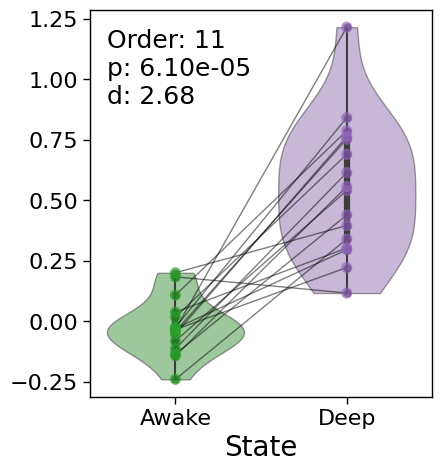

/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


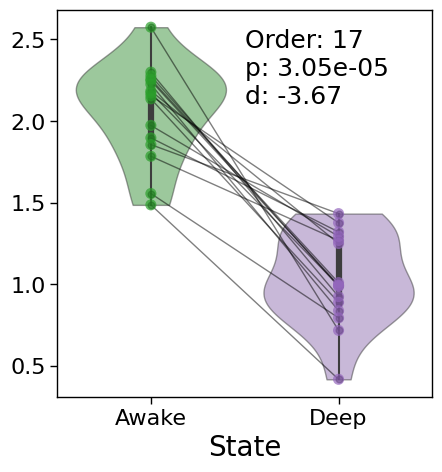

nplet greedy max:
[['CinguloOperc' '0']
 ['Default' '0']
 ['FrontoParietal' '1']
 ['DorsalAttn' '2']
 ['SMmouth' '3']
 ['Auditory' '2']
 ['FrontoParietal' '2']
 ['VentralAttn' '3']]
nplet greedy min:
[['CinguloOperc' '2']
 ['CinguloOperc' '3']
 ['DorsalAttn' '3']
 ['Default' '1']
 ['CinguloParie' '2']
 ['CinguloOperc' '1']
 ['Visual' '1']
 ['Default' '4']
 ['FrontoParietal' '0']
 ['CinguloParie' '0']
 ['CinguloParie' '4']
 ['CinguloParie' '3']
 ['RetrosplenialTemporal' '4']
 ['CinguloOperc' '4']]


/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


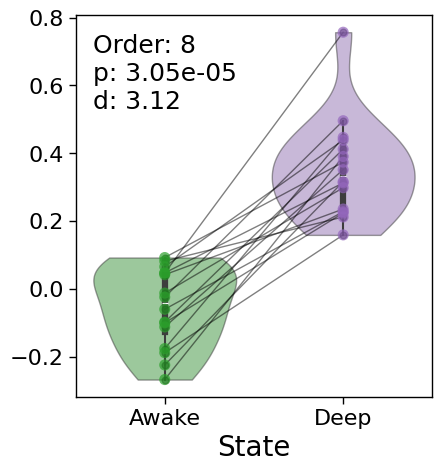

/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


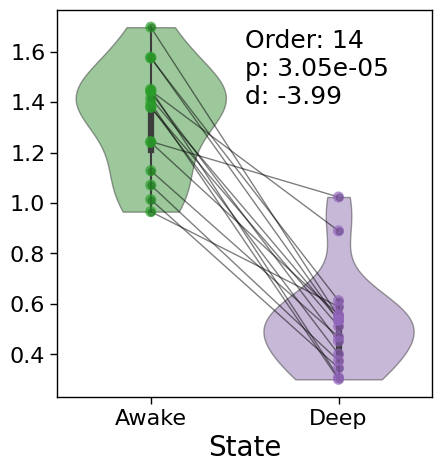

In [7]:
results_optimizers = []

best_order_max = scores_greedy_max.mean(axis=0).argmax()+3
best_repeat_max = scores_greedy_max[:, best_order_max-3].argmax()
nplet_best_max = solution_greedy_max[best_repeat_max,:best_order_max]

best_order_min = scores_greedy_min.mean(axis=0).argmin()+3
best_repeat_min = scores_greedy_min[:, best_order_min-3].argmin()
nplet_best_min = solution_greedy_min[best_repeat_min,:best_order_min]

results_optimizers.append({
    'label': 'Greedy - Mean - max',
    'state': 'Awake',
    'order': len(nplet_best_max),
    'o': nplets_measures(Xs_awake, nplet_best_max.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_max
})

results_optimizers.append({
    'label': 'Greedy - Mean - max',
    'state': 'Deep',
    'order': len(nplet_best_max),
    'o': nplets_measures(Xs_deep, nplet_best_max.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_max
})

results_optimizers.append({
    'label': 'Greedy - Mean - min',
    'state': 'Awake',
    'order': len(nplet_best_min),
    'o': nplets_measures(Xs_awake, nplet_best_min.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_min
})

results_optimizers.append({
    'label': 'Greedy - Mean - min',
    'state': 'Deep',
    'order': len(nplet_best_min),
    'o': nplets_measures(Xs_deep, nplet_best_min.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_min
})

print(best_order_max)
print(nplet_best_max)

plot_contrast(Xs, nplet_best_max)
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_greedy_mean_max.pdf'))
plt.show()

plot_contrast(Xs,nplet_best_min, text_left=False)
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_greedy_mean_min.pdf'))
plt.show()

best_order_max = scores_greedy_max.max(axis=0).argmax()+3
best_repeat_max = scores_greedy_max[:, best_order_max-3].argmax()
nplet_best_max = solution_greedy_max[best_repeat_max,:best_order_max]

best_order_min = scores_greedy_min.min(axis=0).argmin()+3
best_repeat_min = scores_greedy_min[:, best_order_min-3].argmin()
nplet_best_min = solution_greedy_min[best_repeat_min,:best_order_min]

results_optimizers.append({
    'label': 'Greedy - Max',
    'state': 'Awake',
    'order': len(nplet_best_max),
    'o': nplets_measures(Xs_awake, nplet_best_max.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_max
})

results_optimizers.append({
    'label': 'Greedy - Max',
    'state': 'Deep',
    'order': len(nplet_best_max),
    'o': nplets_measures(Xs_deep, nplet_best_max.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_max
})

results_optimizers.append({
    'label': 'Greedy - Min',
    'state': 'Awake',
    'order': len(nplet_best_min),
    'o': nplets_measures(Xs_awake, nplet_best_min.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_min
})

results_optimizers.append({
    'label': 'Greedy - Min',
    'state': 'Deep',
    'order': len(nplet_best_min),
    'o': nplets_measures(Xs_deep, nplet_best_min.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_min
})

print('nplet greedy max:')
print(df_columns[nplet_best_max])
print('nplet greedy min:')
print(df_columns[nplet_best_min])

plot_contrast(Xs, nplet_best_max)
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_greedy_max.pdf'))
plt.show()

plot_contrast(Xs, nplet_best_min, text_left=False)
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_greedy_min.pdf'))
plt.show()

# Multi order annealing

In [8]:
solution_annealing_multi_order_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_annealing_effect_size_max.npy')
scores_annealing_multi_order_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_annealing_effect_size_max.npy')

solution_annealing_multi_order_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_annealing_effect_size_min.npy')
scores_annealing_multi_order_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_annealing_effect_size_min.npy')

2024-11-11 19:34:31,592 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-11 19:34:31,601 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


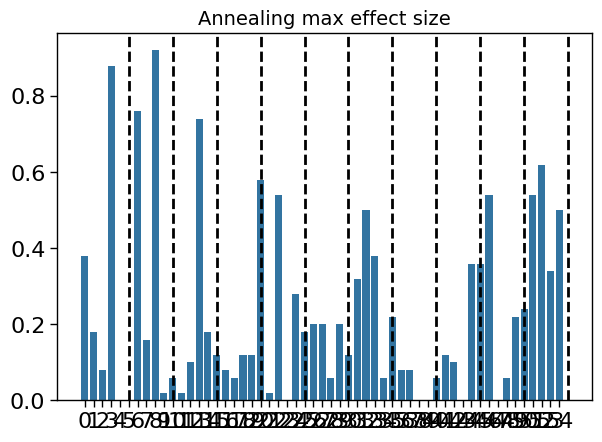

2024-11-11 19:34:31,964 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-11-11 19:34:31,970 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


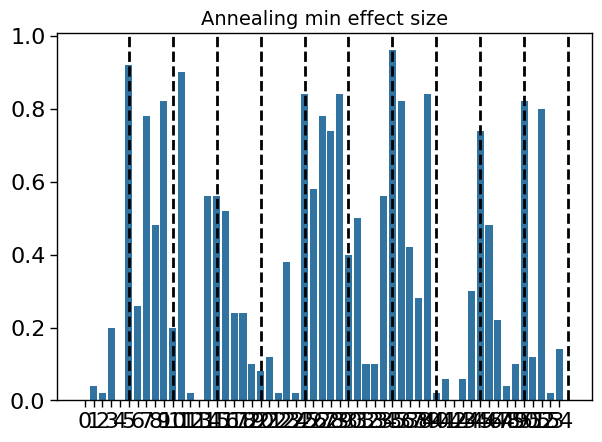

In [9]:
sns.barplot(solution_annealing_multi_order_max.mean(axis=0))

# add vertical lines every 5 x ticks
for i in range(5, 56, 5):
    plt.axvline(i, color='black', linestyle='--')
    
plt.title('Annealing max effect size')
plt.tight_layout()
plt.show()
    
sns.barplot(solution_annealing_multi_order_min.mean(axis=0))

# add vertical lines every 5 x ticks
for i in range(5, 56, 5):
    plt.axvline(i, color='black', linestyle='--')

plt.title('Annealing min effect size')
plt.tight_layout()
plt.show()

2.9240080182033323
-4.767594403988059
12
13
nplet SA max:
[['VentralAttn' '0']
 ['VentralAttn' '3']
 ['CinguloParie' '1']
 ['CinguloParie' '3']
 ['Visual' '3']
 ['Visual' '4']
 ['RetrosplenialTemporal' '1']
 ['RetrosplenialTemporal' '2']
 ['Default' '0']
 ['DorsalAttn' '1']
 ['FrontoParietal' '1']
 ['FrontoParietal' '2']]
nplet SA min:
[['CinguloParie' '0']
 ['CinguloParie' '2']
 ['CinguloParie' '3']
 ['CinguloParie' '4']
 ['Visual' '1']
 ['SMhand' '3']
 ['CinguloOperc' '0']
 ['CinguloOperc' '2']
 ['CinguloOperc' '3']
 ['CinguloOperc' '4']
 ['Default' '0']
 ['DorsalAttn' '3']
 ['FrontoParietal' '4']]


/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


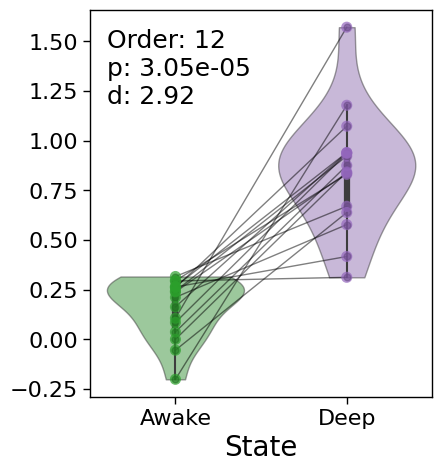

/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


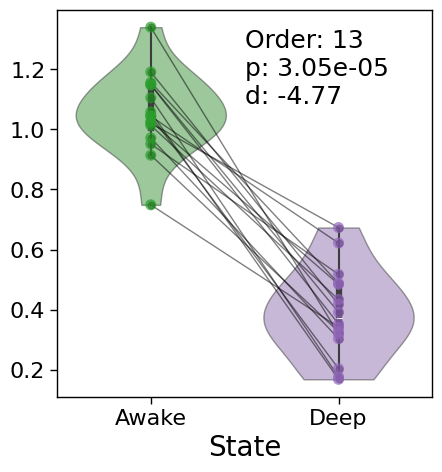

In [10]:
nplet_best_max = solution_annealing_multi_order_max[scores_annealing_multi_order_max.argmax()]
nplet_best_max
nplet_best_max = np.where(nplet_best_max)[0]

nplet_best_min = solution_annealing_multi_order_min[scores_annealing_multi_order_min.argmin()]
nplet_best_min
nplet_best_min = np.where(nplet_best_min)[0]

print(scores_annealing_multi_order_max.max().item())
print(scores_annealing_multi_order_min.min().item())
print(len(nplet_best_max))
print(len(nplet_best_min))


print('nplet SA max:')
print(df_columns[nplet_best_max])
print('nplet SA min:')
print(df_columns[nplet_best_min])


plot_contrast(Xs, nplet_best_max)

plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_annealing_max.pdf'))
plt.show()

plot_contrast(Xs, nplet_best_min, text_left=False)
plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_annealing_min.pdf'))
plt.show()

results_optimizers.append({
    'label': 'Annealing - Max',
    'state': 'Awake',
    'order': len(nplet_best_max),
    'o': nplets_measures(Xs_awake, nplet_best_max.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_max
})

results_optimizers.append({
    'label': 'Annealing - Max',
    'state': 'Deep',
    'order': len(nplet_best_max),
    'o': nplets_measures(Xs_deep, nplet_best_max.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_max
})

results_optimizers.append({
    'label': 'Annealing - Min',
    'state': 'Awake',
    'order': len(nplet_best_min),
    'o': nplets_measures(Xs_awake, nplet_best_min.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_min
})

results_optimizers.append({
    'label': 'Annealing - Min',
    'state': 'Deep',
    'order': len(nplet_best_min),
    'o': nplets_measures(Xs_deep, nplet_best_min.reshape(1,-1))[0,:,2].numpy(),
    'nplet': nplet_best_min
})

/tmp/ipykernel_2207095/288235071.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2207095/288235071.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


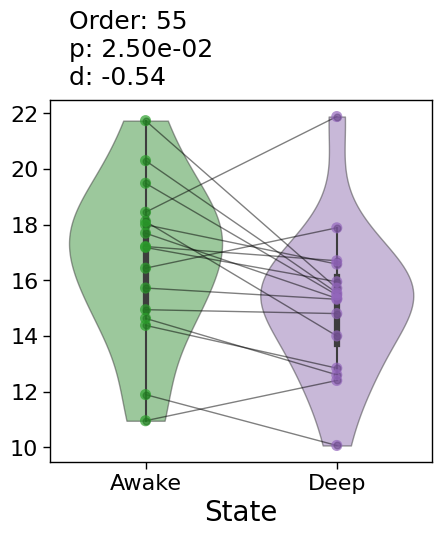

In [11]:
nplet_all = np.arange(55).reshape(1,-1)

results_optimizers.append({
    'label': 'Whole-Brain',
    'state': 'Awake',
    'order': nplet_all.shape[1],
    'o': nplets_measures(Xs_awake, nplet_all)[0,:,2].numpy(),
    'nplet': nplet_all
})

results_optimizers.append({
    'label': 'Whole-Brain',
    'state': 'Deep',
    'order': nplet_all.shape[1],
    'o': nplets_measures(Xs_deep, nplet_all)[0,:,2].numpy(),
    'nplet': nplet_all
})

plot_contrast(Xs, np.arange(55), text_top=True)

# get figure
fig = plt.gcf()

# set size
fig.set_size_inches(4.8, 6)


plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'contrast_whole_brain.pdf'))
plt.show()

# Exaustivo y heruísticas

In [12]:
'''
# Group awake

Xs_awake = Xs[:16]

df_exaust_awake_low = multi_order_measures(Xs_awake, max_order=6, batch_size=10000)
nplet_cols = [f'var_{i}' for i in range(55)]
df_exaust_awake_low.loc[np.arange(len(df_exaust_awake_low)), 'nplet'] = df_exaust_awake_low[nplet_cols].apply(lambda x: ''.join(x.values.astype(int).astype(str)), axis=1)
df_exaust_awake_low = df_exaust_awake_low.groupby(['order', 'nplet']).mean().reset_index()

df_exaust_awake_high = multi_order_measures(Xs_awake, min_order=55-6, batch_size=10000)
nplet_cols = [f'var_{i}' for i in range(55)]
df_exaust_awake_high.loc[np.arange(len(df_exaust_awake_high)), 'nplet'] = df_exaust_awake_high[nplet_cols].apply(lambda x: ''.join(x.values.astype(int).astype(str)), axis=1)
df_exaust_awake_high = df_exaust_awake_high.groupby(['order', 'nplet']).mean().reset_index()

# Group deep

Xs_deep = Xs[16:]

df_exaust_deep_low = multi_order_measures(Xs_deep, max_order=4, batch_size=10000)
nplet_cols = [f'var_{i}' for i in range(55)]
df_exaust_deep_low.loc[np.arange(len(df_exaust_deep_low)), 'nplet'] = df_exaust_deep_low[nplet_cols].apply(lambda x: ''.join(x.values.astype(int).astype(str)), axis=1)
df_exaust_deep_low = df_exaust_deep_low.groupby(['order', 'nplet']).mean().reset_index()

df_exaust_deep_high = multi_order_measures(Xs_deep, min_order=53, batch_size=10000)
nplet_cols = [f'var_{i}' for i in range(55)]
df_exaust_deep_high.loc[np.arange(len(df_exaust_deep_high)), 'nplet'] = df_exaust_deep_high[nplet_cols].apply(lambda x: ''.join(x.values.astype(int).astype(str)), axis=1)
df_exaust_deep_high = df_exaust_deep_high.groupby(['order', 'nplet']).mean().reset_index()


df_exaust_awake_low_min = df_exaust_awake_low.groupby('order').min().reset_index()
df_exaust_awake_low_max = df_exaust_awake_low.groupby('order').max().reset_index()
df_exaust_awake_high_min = df_exaust_awake_high.groupby('order').min().reset_index()
df_exaust_awake_high_max = df_exaust_awake_high.groupby('order').max().reset_index()
df_exaust_deep_low_min = df_exaust_deep_low.groupby('order').min().reset_index()
df_exaust_deep_low_max = df_exaust_deep_low.groupby('order').max().reset_index()
df_exaust_deep_high_min = df_exaust_deep_high.groupby('order').min().reset_index()
df_exaust_deep_high_max = df_exaust_deep_high.groupby('order').max().reset_index()

df_exaust_awake_low_min['label'] = 'Awake Low Min'
df_exaust_awake_low_max['label'] = 'Awake Low Max'
df_exaust_awake_high_min['label'] = 'Awake High Min'
df_exaust_awake_high_max['label'] = 'Awake High Max'
df_exaust_deep_low_min['label'] = 'Deep Low Min'
df_exaust_deep_low_max['label'] = 'Deep Low Max'
df_exaust_deep_high_min['label'] = 'Deep High Min'
df_exaust_deep_high_max['label'] = 'Deep High Max'
'''

"\n# Group awake\n\nXs_awake = Xs[:16]\n\ndf_exaust_awake_low = multi_order_measures(Xs_awake, max_order=6, batch_size=10000)\nnplet_cols = [f'var_{i}' for i in range(55)]\ndf_exaust_awake_low.loc[np.arange(len(df_exaust_awake_low)), 'nplet'] = df_exaust_awake_low[nplet_cols].apply(lambda x: ''.join(x.values.astype(int).astype(str)), axis=1)\ndf_exaust_awake_low = df_exaust_awake_low.groupby(['order', 'nplet']).mean().reset_index()\n\ndf_exaust_awake_high = multi_order_measures(Xs_awake, min_order=55-6, batch_size=10000)\nnplet_cols = [f'var_{i}' for i in range(55)]\ndf_exaust_awake_high.loc[np.arange(len(df_exaust_awake_high)), 'nplet'] = df_exaust_awake_high[nplet_cols].apply(lambda x: ''.join(x.values.astype(int).astype(str)), axis=1)\ndf_exaust_awake_high = df_exaust_awake_high.groupby(['order', 'nplet']).mean().reset_index()\n\n# Group deep\n\nXs_deep = Xs[16:]\n\ndf_exaust_deep_low = multi_order_measures(Xs_deep, max_order=4, batch_size=10000)\nnplet_cols = [f'var_{i}' for i in r

In [13]:
nplets_greedy_awake_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_greedy_awake_max.npy')
scores_greedy_awake_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_greedy_awake_max.npy')

nplets_greedy_awake_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_greedy_awake_min.npy')
scores_greedy_awake_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_greedy_awake_min.npy')

nplets_greedy_deep_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_greedy_deep_max.npy')
scores_greedy_deep_max = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_greedy_deep_max.npy')

nplets_greedy_deep_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/nplets_greedy_deep_min.npy')
scores_greedy_deep_min = np.load('/home/laouen.belloli/Documents/git/Oinformation/benchmarking/results/anesthesia/scores_greedy_deep_min.npy')

In [14]:
def greedy_to_df(scores, label):
    
    if 'Max' in label:
        best_score = scores.max(axis=0)
    else:
        best_score = scores.min(axis=0)

    orders = np.arange(3, 56)
    
    return pd.DataFrame({
        'order': orders,
        'label': label,
        'o': best_score
    })
    
df_greedy_awake_max = greedy_to_df(scores_greedy_awake_max, 'Awake Greedy Max')
df_greedy_awake_min = greedy_to_df(scores_greedy_awake_min, 'Awake Greedy Min')
df_greedy_deep_max = greedy_to_df(scores_greedy_deep_max, 'Deep Greedy Max')
df_greedy_deep_min = greedy_to_df(scores_greedy_deep_min, 'Deep Greedy Min')

In [15]:
df_wale = pd.concat([
    #df_exaust_awake_low_min[['order', 'label', 'o']],
    #df_exaust_awake_low_max[['order', 'label', 'o']],
    #df_exaust_awake_high_min[['order', 'label', 'o']],
    #df_exaust_awake_high_max[['order', 'label', 'o']],
    #df_exaust_deep_low_min[['order', 'label', 'o']],
    #df_exaust_deep_low_max[['order', 'label', 'o']],
    #df_exaust_deep_high_min[['order', 'label', 'o']],
    #df_exaust_deep_high_max[['order', 'label', 'o']], 
    df_greedy_awake_max,
    df_greedy_awake_min,
    df_greedy_deep_max,
    df_greedy_deep_min
])

In [16]:
def plot_wale_curve(df, state, ax):
    
    # get the blue and orange seaborn default colors
    color = state_colors[state]
    
    df_state = df[df['label'].str.contains(state)]

    # Plot the greedy search results 
    sns.lineplot(
        x='order',
        y='o',
        data=df_state[df_state['label'].str.contains('Greedy Max')],
        color=color,
        label=rf'$Greedy(\Omega({state}))$',
        ax=ax
    )
    sns.lineplot(
        x='order',
        y='o',
        data=df_state[df_state['label'].str.contains('Greedy Min')],
        color=color,
        ax=ax
    )

    plt.fill_between(
        df_state[df_state['label'].str.contains('Greedy Min')]['order'],
        df_state[df_state['label'].str.contains('Greedy Min')]['o'],
        df_state[df_state['label'].str.contains('Greedy Max')]['o'],
        alpha=0.2, color=color,
    )

def plot_found_nplets(df, state, ax, color, markersize):
    
    df_opt_state = df[df['state'] == state]
    agg_df = df_opt_state.groupby(['label', 'order'])['o'].agg(['mean', 'std']).reset_index()
    
    if state == 'Awake':
        agg_df['order'] += 0.5
    
    # Add error bars manually
    plt.errorbar(
        agg_df['order'],
        agg_df['mean'],
        yerr=agg_df['std'],
        fmt='none',
        ecolor=color,
        elinewidth=2,
        capsize=3,
        alpha=1.
    )
    
    sns.lineplot(
        x='order',
        y='mean',
        data=agg_df,
        color=color,
        ax=ax,
        style='label',
        markers=['o', 's', 'D'],
        markersize=8
    )


In [17]:
df_main = pd.json_normalize(results_optimizers).drop(columns=['nplet'])
o_expanded = pd.DataFrame(df_main['o'].tolist(), columns=[f'o{i}' for i in range(16)])
df_final = pd.concat([df_main.drop(columns=['o']), o_expanded], axis=1)
df_heurist = pd.melt(
    df_final,
    id_vars=['label', 'state', 'order'],
    value_vars=[f'o{i}' for i in range(16)],
    var_name='o_index',
    value_name='o'
)
print(df_heurist['label'].unique())

#df_heurist = df_heurist[df_heurist['label'].isin(['Annealing - Max', 'Greedy - Max', 'Whole-Brain'])]

['Greedy - Mean - max' 'Greedy - Mean - min' 'Greedy - Max' 'Greedy - Min'
 'Annealing - Max' 'Annealing - Min' 'Whole-Brain']


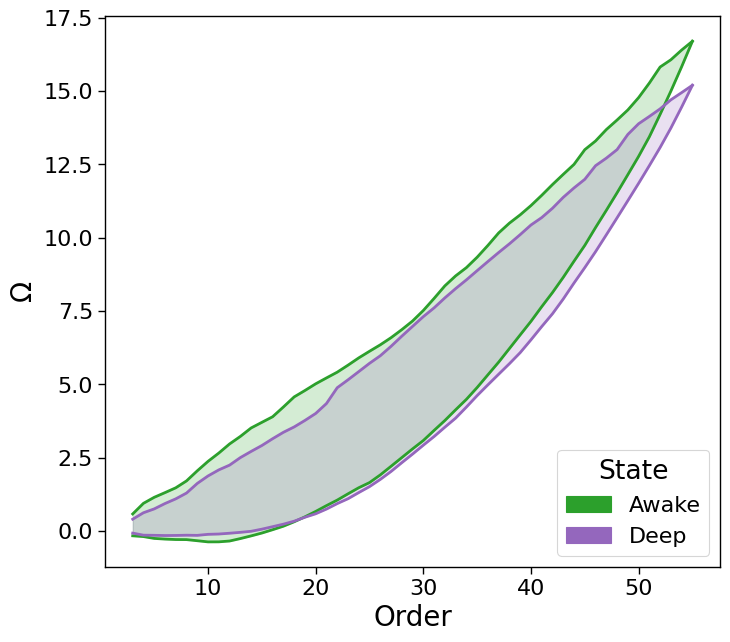

In [18]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(1.2*6.4, 6.8))

plot_wale_curve(df_wale, 'Awake', ax)
plot_wale_curve(df_wale, 'Deep', ax)

# Eliminamos esa information porque queda muy cargado
#plot_found_nplets(df_heurist, 'Awake', ax, blue, 6)
#plot_found_nplets(df_heurist, 'Deep', ax, orange, 6)

ax.get_legend().remove()

# add une legends with two filled squared blue and orange with labels ['Awake', 'Deep']
state_legend = plt.legend(
    handles=[
        Patch(facecolor=state_colors['Awake'], edgecolor=state_colors['Awake'], label='Awake'),
        Patch(facecolor=state_colors['Deep'], edgecolor=state_colors['Deep'], label='Deep')
    ],
    labels=['Awake', 'Deep'],
    title='State',
    loc='lower right',
    #bbox_to_anchor=(1, 1)
)

#marker_styles = ['o', 's', 'D']  # Circle, Square, Diamond

#legend_elements_markers = [
#    plt.Line2D([0], [0], marker=marker, color='w', label=f'Marker {i+1}',
#           markerfacecolor='black', markersize=10)
#    for i, marker in enumerate(marker_styles)
#]

# Add the 'Markers' Legend
#plt.legend(
#    handles=legend_elements_markers,
#    title='Markers',
#    loc='upper left',
#    bbox_to_anchor=(1, 0.8)
#)

# To ensure both legends are displayed, add the first legend back
#plt.gca().add_artist(state_legend)

plt.xlabel('Order')
plt.ylabel(r'$\Omega$')

plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'wale_curve.pdf'))
plt.show()

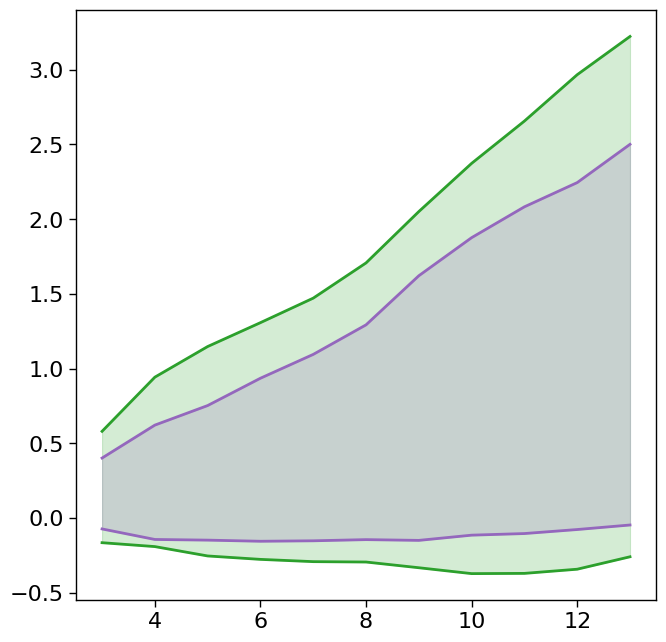

In [19]:
fig, ax = plt.subplots(figsize=(1.1*6.4, 6.8))

plot_wale_curve(df_wale[df_wale['order'] < 14], 'Awake', ax)
plot_wale_curve(df_wale[df_wale['order'] < 14], 'Deep', ax)
#plot_found_nplets(df_heurist[df_heurist['order'] < 13], 'Awake', ax, blue, 8)
#plot_found_nplets(df_heurist[df_heurist['order'] < 13], 'Deep', ax, orange, 8)

ax.get_legend().remove()

plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(fig_path, 'wale_curve_inset.pdf'))
plt.show()